In [57]:
import os
import re
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [58]:
class logs_analysis:
    def __init__(self, root_dir,create_or_not):
        self.create_or_not=create_or_not
        self.root_dir = root_dir
        self.folder_files_dict = self._find_folders_files()
        self.df=self.create_dataframe()

    def _find_folders_files(self):
        folder_files_dict = {}
        # Iterate over each instance from 1 to 14
        for i in range(1, 15):
            instance_folder = f"{i}.in_simulations"
            instance_folder_path = os.path.join(self.root_dir, instance_folder)

            if os.path.isdir(instance_folder_path):
                # Iterate over each heuristic policy folder within the instance folder
                heuristic_folders = [
                    f for f in os.listdir(instance_folder_path) if os.path.isdir(os.path.join(instance_folder_path, f))
                ]

                for heuristic_folder in heuristic_folders:
                    heuristic_folder_path = os.path.join(instance_folder_path, heuristic_folder)

                    # List all log files in the heuristic folder
                    log_files = [
                        f for f in os.listdir(heuristic_folder_path) if f.endswith(".log")
                    ]

                    # Store the heuristic folder and its log files in the dictionary
                    folder_files_dict[os.path.join(instance_folder, heuristic_folder)] = log_files

        return folder_files_dict
    
    def extract_log_data(self, file_path):
        with open(file_path, "r") as file:
            content = file.read()

            # Use regex to find the required information
            best_node = re.search(r"Best node:\s*(.+)", content)
            preprocess_time = re.search(
                r"Time to preprocess the data:\s*([\d.]+) seconds", content
            )
            solution_time = re.search(
                r"Time to find the solution:\s*([\d.]+) seconds", content
            )
            total_time = re.search(r"Total time:\s*([\d.]+) seconds", content)
            
            # Count occurrences of SELECTION and SIMULATION
            num_selections = len(re.findall(r"SELECTION", content))
            num_simulations = len(re.findall(r"SIMULATION", content))

            # Extracted values (if found)
            best_node = best_node.group(1) if best_node else "Not found"
            preprocess_time = (
                preprocess_time.group(1) if preprocess_time else "Not found"
            )
            solution_time = solution_time.group(1) if solution_time else "Not found"
            total_time = total_time.group(1) if total_time else "Not found"

            # Return the results as a dictionary
            return {
                "Best node": best_node,
                "Time to preprocess the data": preprocess_time,
                "Time to find the solution": solution_time,
                "Total time": total_time,
                "Number of SELECTION phases": num_selections,
                "Number of SIMULATION phases": num_simulations,
            }

    def analyze_logs(self):
        results = {}
        for folder, log_files in self.folder_files_dict.items():
            folder_results = {}
            for log_file in log_files:
                log_file_path = os.path.join(self.root_dir, folder, log_file)
                log_data = self.extract_log_data(log_file_path)
                folder_results[log_file] = log_data
            results[folder] = folder_results
        return results

    def create_dataframe(self):
        if not self.create_or_not:
            return pd.read_excel("Simulation output.xlsx")
        else:
            data = []
            analysis_results = self.analyze_logs()

            for folder, logs in analysis_results.items():
                # Split the folder path correctly based on the new folder structure
                folder_parts = os.path.basename(folder).split('_')
                instance_path = folder_parts[0]+".in"

                # Extract the parts according to the new structure
                number_childrens = folder_parts[1]
                desired_simulation_policy = folder_parts[2] + "_" + folder_parts[3]
                desired_expansion_policy = folder_parts[4] + "_" + folder_parts[5]
                ratio_expansion = folder_parts[6]
                number_simulation = folder_parts[7]
                desired_selection_policy = folder_parts[8]
                cp = folder_parts[9]

                for log_file, log_data in logs.items():
                    # Parse the 'Best node' dictionary string to an actual dictionary
                    best_node_dict = ast.literal_eval(log_data['Best node'])

                    row = {
                        'Folder': folder,
                        'File': log_file,
                        'Instance Path': instance_path,
                        'Number of Childrens': number_childrens,
                        'Desired Simulation Policy': desired_simulation_policy,
                        'Desired Expansion Policy': desired_expansion_policy,
                        'Ratio Expansion': ratio_expansion,
                        'Number of Simulations': number_simulation,
                        'Desired Selection Policy': desired_selection_policy,
                        'Cp': cp,
                        'Time to preprocess the data': log_data['Time to preprocess the data'],
                        'Time to find the solution': log_data['Time to find the solution'],
                        'Total time': log_data['Total time'],
                        'Number of Selection': log_data['Number of SELECTION phases'],
                        'Number of Simulation': log_data['Number of SIMULATION phases'],
                        'Current Airport': best_node_dict.get('current_airport', 'Not found'),
                        'Total Cost': best_node_dict.get('total_cost', 'Not found'),
                        'Path': best_node_dict.get('path', 'Not found'),
                    }
                    data.append(row)

            df = pd.DataFrame(data)
            df.loc[df['Desired Expansion Policy'].str.contains('top_k'), 'Ratio Expansion'] = np.nan
            # Extract the parameters by removing the trailing "_digit.log"
            df['Parameters'] = df['File'].str.extract(r'(.+)_\d+\.log')

            
            return df

In [59]:
logs_analysis = logs_analysis('Flight connections dataset',create_or_not=False)
instance=1

number_childrens_options
desired_expansion_policy_options
ratio_expansion_options
desired_simulation_policy_options
desired_selection_policy_options
cp_options

Index(['Folder', 'File', 'Instance Path', 'Number of Childrens',
       'Desired Simulation Policy', 'Desired Expansion Policy',
       'Ratio Expansion', 'Number of Simulations', 'Desired Selection Policy',
       'Cp', 'Time to preprocess the data', 'Time to find the solution',
       'Total time', 'Number of Selection', 'Number of Simulation',
       'Current Airport', 'Total Cost', 'Path', 'Parameters'],
      dtype='object')

In [177]:
class data_visualisation:
    def __init__(self, df):
        self.df=df
        
    def _filter_instance(self, instance_number):
        instance_str = f'{instance_number}.in.in'
        df_instance = self.df[self.df['Instance Path'] == instance_str]
        return df_instance
                        
    def summarise_and_plot(self, instance_number):

        df = self.df.copy()
        
        # Filter the DataFrame by the specific instance number
        instance_str = f'{instance_number}.in.in'
        df_instance = df[df['Instance Path'] == instance_str]

        if df_instance.empty:
            print(f"No data found for instance {instance_number}")
            return

        # Convert relevant columns to numeric if possible
        df_instance['Total time'] = pd.to_numeric(df_instance['Total time'], errors='coerce')
        df_instance['Time to preprocess the data'] = pd.to_numeric(df_instance['Time to preprocess the data'], errors='coerce')
        df_instance['Time to find the solution'] = pd.to_numeric(df_instance['Time to find the solution'], errors='coerce')
        df_instance['Total Cost'] = pd.to_numeric(df_instance['Total Cost'], errors='coerce')
        df_instance['Number of Childrens'] = pd.to_numeric(df_instance['Number of Childrens'], errors='coerce')
        df_instance['Ratio Expansion'] = pd.to_numeric(df_instance['Ratio Expansion'], errors='coerce')
        df_instance['Number of Simulations'] = pd.to_numeric(df_instance['Number of Simulations'], errors='coerce')
        df_instance['Cp'] = pd.to_numeric(df_instance['Cp'], errors='coerce')
        

        #print("Summary Statistics:\n", summary)

        # Define the parameters to plot
        parameters = ['Cp', 'Number of Childrens', 'Desired Expansion Policy', 'Ratio Expansion', 'Desired Simulation Policy', 'Desired Selection Policy']

        # Calculate figure size based on the number of parameters
        num_params = len(parameters)
        fig_width = 6 * num_params  # 6 units width per parameter
        fig_height = 6  # Keep the height fixed for each row

        # Plotting Time to Find Solution vs parameters in the first row
        plt.figure(figsize=(fig_width, fig_height * 2))

        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1)  # First row
            sns.violinplot(x=param, y='Time to find the solution', data=df_instance, inner="quartile", split=True)
            plt.title(f'Time to Find Solution vs {param}')
            plt.xlabel(param)
            plt.ylabel('Time to Find Solution (seconds)')

        # Plotting Total Cost vs parameters in the second row
        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1 + num_params)  # Second row
            sns.violinplot(x=param, y='Total Cost', data=df_instance, inner="quartile", split=True)
            plt.title(f'Total Cost vs {param}')
            plt.xlabel(param)
            plt.ylabel('Total Cost')

        plt.tight_layout()
        plt.show()
        
    def plot_selection_simulation_counts(self, instance_number):
        # Create the DataFrame
        df = self.df.copy()

        # Filter the DataFrame by the specific instance number
        instance_str = f'{instance_number}.in.in'
        df_instance = df[df['Instance Path'] == instance_str]

        if df_instance.empty:
            print(f"No data found for instance {instance_number}")
            return
        
        # Create the Parameters column by removing the trailing "_digit.log"
        df_instance['Parameters'] = df_instance['File'].str.extract(r'(.+)_\d+\.log')

        # Melt the DataFrame to create a single 'Counts' column with 'Category' as Selections/Simulations
        melted_df = pd.melt(df_instance, id_vars=['Parameters'], value_vars=['Number of Selection', 'Number of Simulation'], 
                            var_name='Category', value_name='Counts')

        # Replace 'Number of Selection' and 'Number of Simulation' with more readable labels
        melted_df['Category'] = melted_df['Category'].replace({
            'Number of Selection': 'Selections',
            'Number of Simulation': 'Simulations'
        })
        
        scaler = MinMaxScaler()
        melted_df['Scaled Counts'] = scaler.fit_transform(melted_df[['Counts']])


        # Set up the plot
        plt.figure(figsize=(16, 8))

        # Plot the violin plot with 'Parameters' on x-axis and 'Counts' on y-axis, with 'Category' differentiating the hue
        sns.violinplot(x='Parameters', y='Counts', hue='Category', data=melted_df, split=True, inner="quartile", palette={"Selections": "skyblue", "Simulations": "lightgreen"})

        # Add labels and title
        plt.title(f'Number of Selections and Simulations for Instance {instance_number}')
        plt.xlabel('Parameters')
        plt.ylabel('Counts')
        plt.xticks(rotation=45, ha="right")
        plt.legend(title='Category')

        # Show the plot
        plt.tight_layout()
        plt.show()
    
    def cp_vs_cost(self, instance_number):
        # Create the DataFrame
        df = self.df.copy()

        # Filter the DataFrame by the specific instance number
        instance_str = f'{instance_number}.in.in'
        df_instance = df[df['Instance Path'] == instance_str]

        if df_instance.empty:
            print(f"No data found for instance {instance_number}")
            return


        palette = sns.color_palette("pastel", n_colors=len(df_instance['Desired Selection Policy'].unique()))

        plt.figure(figsize=(16, 8))
        sns.violinplot(data=df_instance,  # Ensure to use df_instance
                    x="Cp",
                    y="Total Cost",
                    hue="Desired Selection Policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Total Cost by Selection Policy - Instance {instance_number}")
        plt.xlabel("Cp Value")
        plt.ylabel("Total Cost")
        plt.tight_layout()
        plt.show()
        
    def cp_vs_total_time(self, instance_number):
        # Create the DataFrame
        df = self.df.copy()

        # Filter the DataFrame by the specific instance number
        instance_str = f'{instance_number}.in.in'
        df_instance = df[df['Instance Path'] == instance_str]

        if df_instance.empty:
            print(f"No data found for instance {instance_number}")
            return


        palette = sns.color_palette("pastel", n_colors=len(df_instance['Desired Selection Policy'].unique()))

        plt.figure(figsize=(16, 8))
        sns.violinplot(data=df_instance,  # Ensure to use df_instance
                    x="Cp",
                    y="Total time",
                    hue="Desired Selection Policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Total time by Selection Policy - Instance {instance_number}")
        plt.xlabel("Cp Value")
        plt.ylabel("Total time")
        plt.tight_layout()
        plt.show()
        
    def cp_vs_number_selection(self, instance_number):
        # Create the DataFrame
        df = self.df.copy()

        # Filter the DataFrame by the specific instance number
        instance_str = f'{instance_number}.in.in'
        df_instance = df[df['Instance Path'] == instance_str]

        if df_instance.empty:
            print(f"No data found for instance {instance_number}")
            return


        palette = sns.color_palette("pastel", n_colors=len(df_instance['Desired Selection Policy'].unique()))

        plt.figure(figsize=(16, 8))
        sns.violinplot(data=df_instance,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of Selection",
                    hue="Desired Selection Policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Total time by Selection Policy - Instance {instance_number}")
        plt.xlabel("Cp Value")
        plt.ylabel("Total time")
        plt.tight_layout()
        plt.show()
        
    def multi_variable_scatter(self, instance_number):
        df = self.df.copy()
        instance_str = f'{instance_number}.in.in'
        df_instance = df[df['Instance Path'] == instance_str]

        if df_instance.empty:
            print(f"No data found for instance {instance_number}")
            return

        sns.pairplot(df_instance, 
                    vars=["Cp", "Total Cost", "Total time","Number of Simulation","Number of Selection"], 
                    hue="Desired Selection Policy", 
                    palette="pastel", 
                    markers=["o", "s", "D", "^"], 
                    plot_kws={'alpha': 0.5})
        plt.suptitle(f'Multi-variable Analysis for Instance {instance_number}', y=1.02)
        plt.show()

In [178]:
DV=data_visualisation(df=logs_analysis.df)

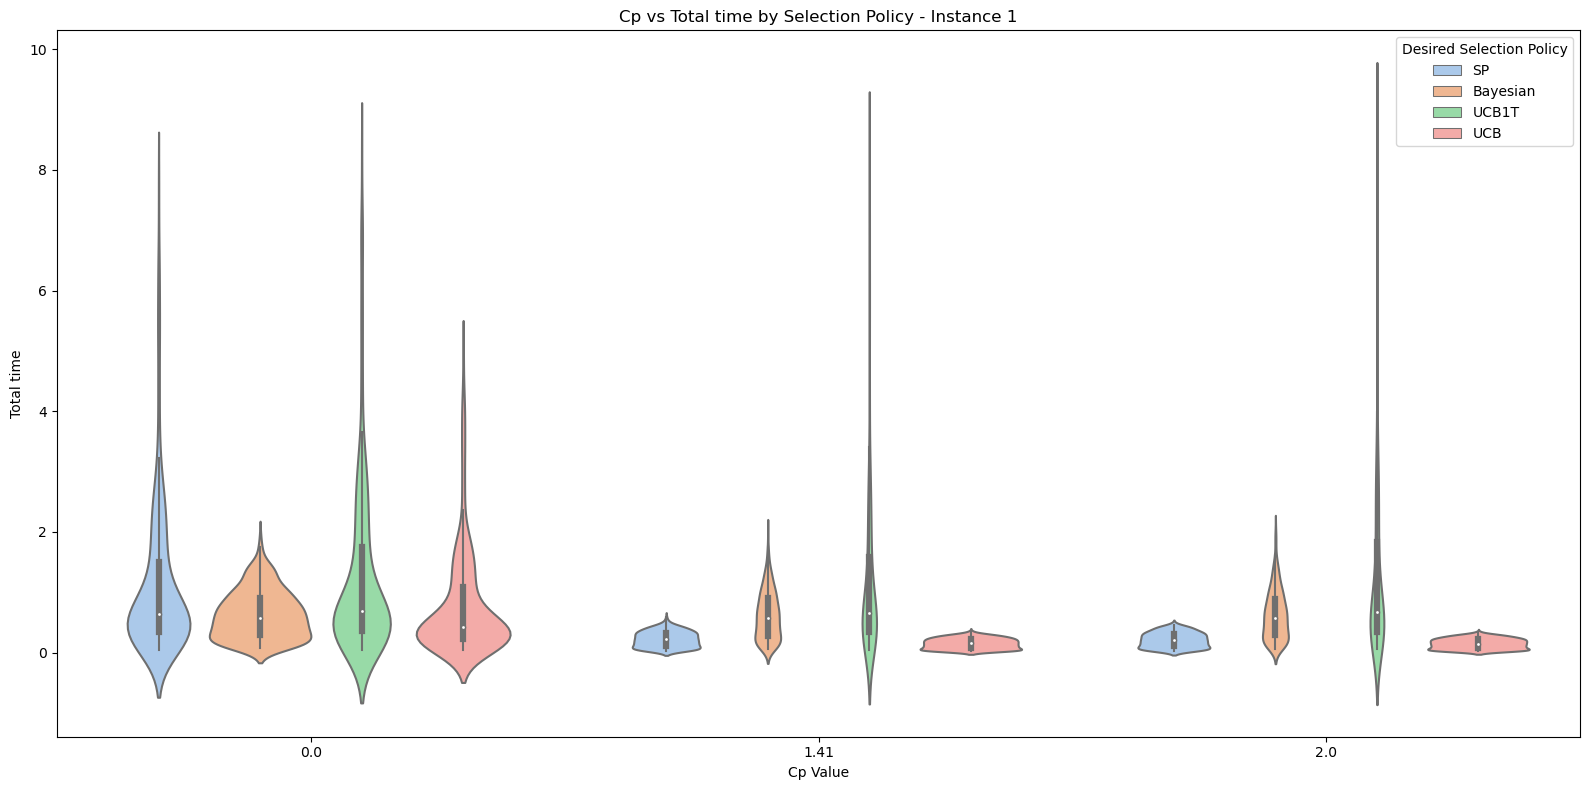

In [179]:
DV.cp_vs_total_time(1)

/Users/adslv/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


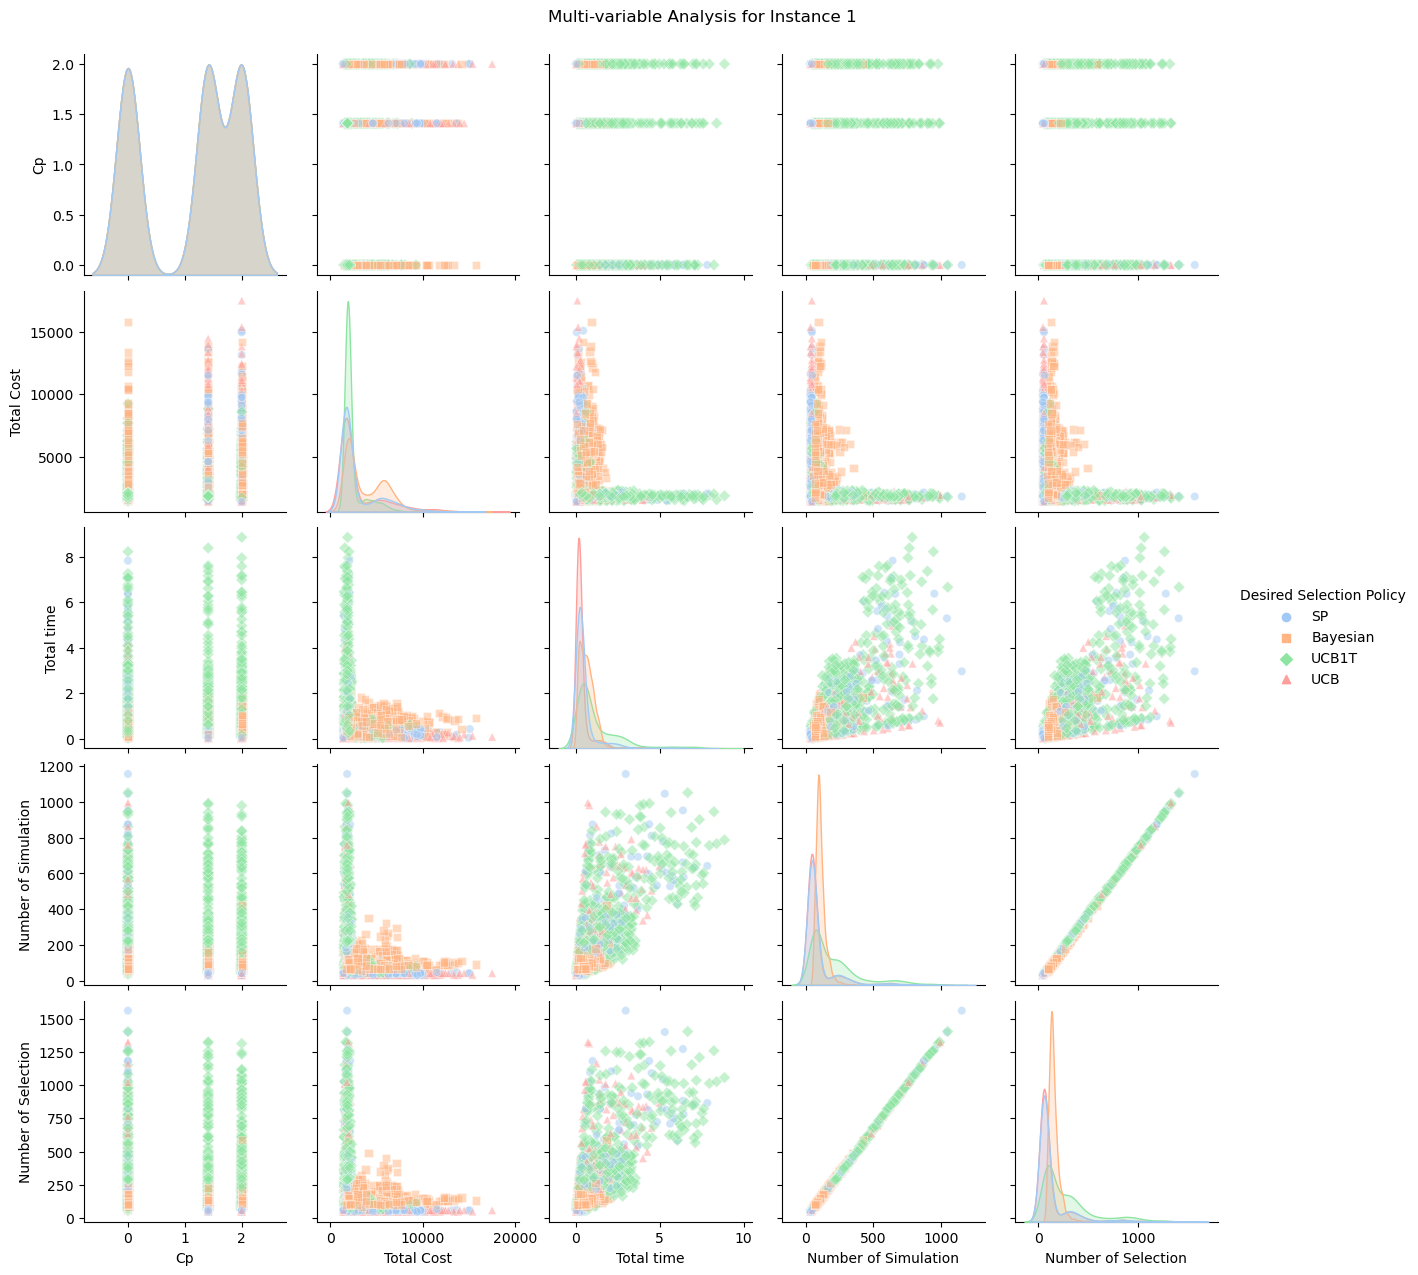

In [180]:
DV.multi_variable_scatter(1)